In [1]:
import numpy as np
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

raw_catalog = "catalog_14dec17.bin"
catalog = pd.read_fwf(raw_catalog, header=1)
catalog = catalog.rename(columns={"#": "RA_DD", "RA": "RA_MM", "Unnamed: 2": "RA_SS", "Unnamed: 4": "DEC_SS"})
catalog['DEC_DD'], catalog['DEC_MM'] = catalog['Dec'].str.split(' ', 1).str
catalog['DEC_DD'] = catalog['DEC_DD'].str.replace("+", "").astype("int")

catalog['DEC_DD'] = catalog['DEC_DD'].astype('int')
catalog['DEC_MM'] = catalog['DEC_MM'].astype('int')
catalog['DEC_SS'] = catalog['DEC_SS'].astype('float')

catalog['RA_DD'] = catalog['RA_DD'].astype('int')
catalog['RA_MM'] = catalog['RA_MM'].astype('int')
catalog['RA_SS'] = catalog['RA_SS'].astype('float')

catalog['DEC_Decimal'] = catalog['DEC_DD']+catalog['DEC_MM']/60+catalog['DEC_SS']/3600
catalog['RA_Decimal'] = catalog['RA_DD']+catalog['RA_MM']/60+catalog['RA_SS']/3600

catalog.sort_values(by="Fint", ascending=False, inplace=True)

C_CM_PER_uS = 29979.2
utctime = '2018-11-17 3:50:00'



In [104]:
def get_nadir_xyz(dec, ra, utctime, height=10*u.km):
    
    ha = ra-obstime.sidereal_time('apparent', '0d').degree
    
    loc = EarthLocation(
        lat=dec, 
        lon=ha, 
        height=height)
    
    return (loc.x.value, loc.y.value, loc.z.value)
    

def get_ra_dec_grids( center_ra, center_dec, width=30.0, res=1.0):
    ra = np.linspace(center_ra-(width/2.0), center_ra+(width/2.0), int(width/res))

    dec = np.linspace(center_dec-(width/2.0), center_dec+(width/2.0), int(width/res))

    dec = np.reshape(dec, [dec.shape[0], 1])
    
    ra = np.tile(ra, [ra.shape[0],1])
    dec = np.tile(dec, [1,ra.shape[0]])
    
    return (ra, dec)

def dec_delay(dec, x, z, x_nadir, z_nadir):

    x_ = x_nadir-x
    z_ = z_nadir-z
    h_ = np.sqrt(np.square(x_)+np.square(z_))
    

    d=np.where(h_==0,0,h_ * np.sin(np.radians(dec-np.arccos(z_/h_))))


    return d

def ra_delay(ra, x, y, x_nadir, y_nadir, gast):
    ha = gast-ra
    x_ = x_nadir-x
    y_ = y_nadir-y
    h_ = np.sqrt(np.square(x_)+np.square(y_))
  
    d = np.where(h_==0,0,h_ * np.sin(np.radians(ha-np.arccos(x_/h_))))


    return d

def geometric_delay(ra, dec, x, y, z, x_nadir, y_nadir, z_nadir, gast):
    d = dec_delay(dec, x, z, x_nadir, z_nadir)
    a = ra_delay(ra, x, y, x_nadir, y_nadir, gast)
    
    return np.sqrt(np.square(a)+np.square(d))/299.792

def plot_matrix(delay_matrix, ra, dec, width, ref_matrix=0, label=""):
  
    
    min_dec = dec-width/2
    max_dec = dec+width/2
    min_ra = ra-width/2
    max_ra = ra+width/2

    sub_catalog=catalog.loc[(catalog['RA_Decimal'] < max_ra) & \
                           (catalog['RA_Decimal'] > min_ra) & \
                           (catalog['DEC_Decimal'] < max_dec) & \
                           (catalog['DEC_Decimal'] > min_dec)][:10]
    plt.suptitle(label)
    plt.tight_layout()
    delay_ax = plt.gca()
    delay_ax.set_xlim((min_ra,max_ra))
    delay_ax.set_ylim((min_dec, max_dec))
    
    plt.xlabel("Right Ascension")
    plt.ylabel("Declination")

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(delay_ax)
    #delay_cax = divider.append_axes("right", size="3%", pad=0.05)    
    diff_ax = divider.append_axes("right", size="96%", pad=0.5)
    diff_ax.set_xlim((min_ra,max_ra))
    diff_ax.set_ylim((min_dec, max_dec))

    diff_cax = divider.append_axes("right", size="3%", pad=0.05)
    diff_ax.yaxis.set_ticklabels([])
    delay_im = delay_ax.contourf(delay_matrix, cmap=plt.cm.viridis, 
               extent=[
                   (ra-width/2),(ra+width/2),
                   (dec-width/2),(dec+width/2)],
                levels=50)
    
    diff_im = diff_ax.contourf(delay_matrix-ref_matrix, cmap=plt.cm.viridis, 
                   extent=[
                       (ra-width/2),(ra+width/2),
                       (dec-width/2),(dec+width/2)],
                    levels=50)
    
    sub_catalog.plot.scatter(x='RA_Decimal', y='DEC_Decimal', s=1, c='k', marker='x', ax=delay_ax)
    sub_catalog.plot.scatter(x='RA_Decimal', y='DEC_Decimal', s=1, c='k', marker='x', ax=diff_ax)
    
    for index, row in sub_catalog.iterrows():
        delay_ax.text(
            x=row.RA_Decimal+0.2, y=row.DEC_Decimal, 
            s=row.Field, horizontalalignment='left', 
            size='small', color='black')
        diff_ax.text(
            x=row.RA_Decimal+0.2, y=row.DEC_Decimal, 
            s=row.Field, horizontalalignment='left', 
            size='small', color='black')
    #plt.colorbar(delay_im, cax=delay_cax, label="")
    plt.colorbar(diff_im, cax=diff_cax, label="uS")
    
    delay_ax.set_title("Delay v. Nadir")
    diff_ax.set_title("Delay v. Observation Reference Site")
    
    plt.savefig("%s.png" % (label))
    plt.show()


    
    
ref_site = sites[0]
ref_loc = EarthLocation(x=ref_site[0]*u.m, y=ref_site[1]*u.m, z=ref_site[2]*u.m)

obstime = Time(utctime, location=EarthLocation(x=ref_site[0]*u.m, y=ref_site[1]*u.m, z=ref_site[2]*u.m))
centercoord=SkyCoord(
        ra=obstime.sidereal_time('apparent'), 
        dec=obstime.location.lat)

ref_site = get_nadir_xyz(dec=centercoord.dec.degree, ra=centercoord.ra.degree, utctime=utctime, height=10*u.km)

gast = obstime.sidereal_time('apparent', '0d').degree
# print(dec_delay(centercoord.dec.value, sites[0][0], sites[0][2], ref_site[0], ref_site[2]))
# print(dec_delay(centercoord.dec.value, sites[1][0], sites[1][2], ref_site[0], ref_site[2]))
# print(dec_delay(centercoord.dec.value, sites[2][0], sites[2][2], ref_site[0], ref_site[2]))
# print()
# print(ra_delay(centercoord.ra.value, sites[0][0], sites[0][1], ref_site[0], ref_site[1], gast))
# print(ra_delay(centercoord.ra.value, sites[1][0], sites[1][1], ref_site[0], ref_site[1], gast))
# print(ra_delay(centercoord.ra.value, sites[2][0], sites[2][1], ref_site[0], ref_site[1], gast))
# print()
# print(geometric_delay(centercoord.ra.value, centercoord.dec.value, sites[0][0], sites[0][1], sites[0][2], ref_site[0], ref_site[1], ref_site[2], gast))
# print(geometric_delay(centercoord.ra.value, centercoord.dec.value, sites[1][0], sites[1][1], sites[1][2], ref_site[0], ref_site[1], ref_site[2], gast))
# print(geometric_delay(centercoord.ra.value, centercoord.dec.value, sites[2][0], sites[2][1], sites[2][2], ref_site[0], ref_site[1], ref_site[2], gast))



utctime = '2018-11-19 12:00:00'


ref_site = sites[0]
ref_loc = EarthLocation(x=ref_site[0]*u.m, y=ref_site[1]*u.m, z=ref_site[2]*u.m)

obstime = Time(utctime, location=ref_loc)
gast = obstime.sidereal_time('apparent', '0d').degree

centercoord=SkyCoord(
        ra=obstime.sidereal_time('apparent'), 
        dec=obstime.location.lat)
nadir = np.vectorize(get_nadir_xyz)(centercoord.dec.degree, centercoord.ra.degree, utctime, height=0)

p = (centercoord.ra.degree, 
        centercoord.dec.degree, 
        ref_site[0], 
        ref_site[1], 
        ref_site[2], 
        nadir[0],
        nadir[1],
        nadir[2],
        gast)

delay = geometric_delay(*p)
print(p)

(161.46164510160756, 38.978897, 1116444.6042431933, -4837644.453798604, 3990496.088344531, array(1116444.60424319), array(-4837644.4537986), array(3990496.08834453), 238.46629610160755)


/Users/paulcaritj/Virtualenvs/NADIA/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/Users/paulcaritj/Virtualenvs/NADIA/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


[[1116444.6042431933, -4837644.453798604, 3990496.088344531, 'TKPK, MD Manor Cir'], [1115788.9347596774, -4837810.200579053, 3990478.65558945, 'TKPK, MD Maple St.'], [1108749.625786537, -4838998.11472454, 3990996.870721371, 'Bethesda, MD'], [887569.7221942554, -5003726.744360795, 3841369.731564422, 'Roanoke, VA'], [799581.9314914319, -5451424.341078086, 3202212.526838078, 'Jacksonville, FL'], [1641424.1567839305, -4225543.073995722, 4471731.044029899, 'Bangor, ME']]


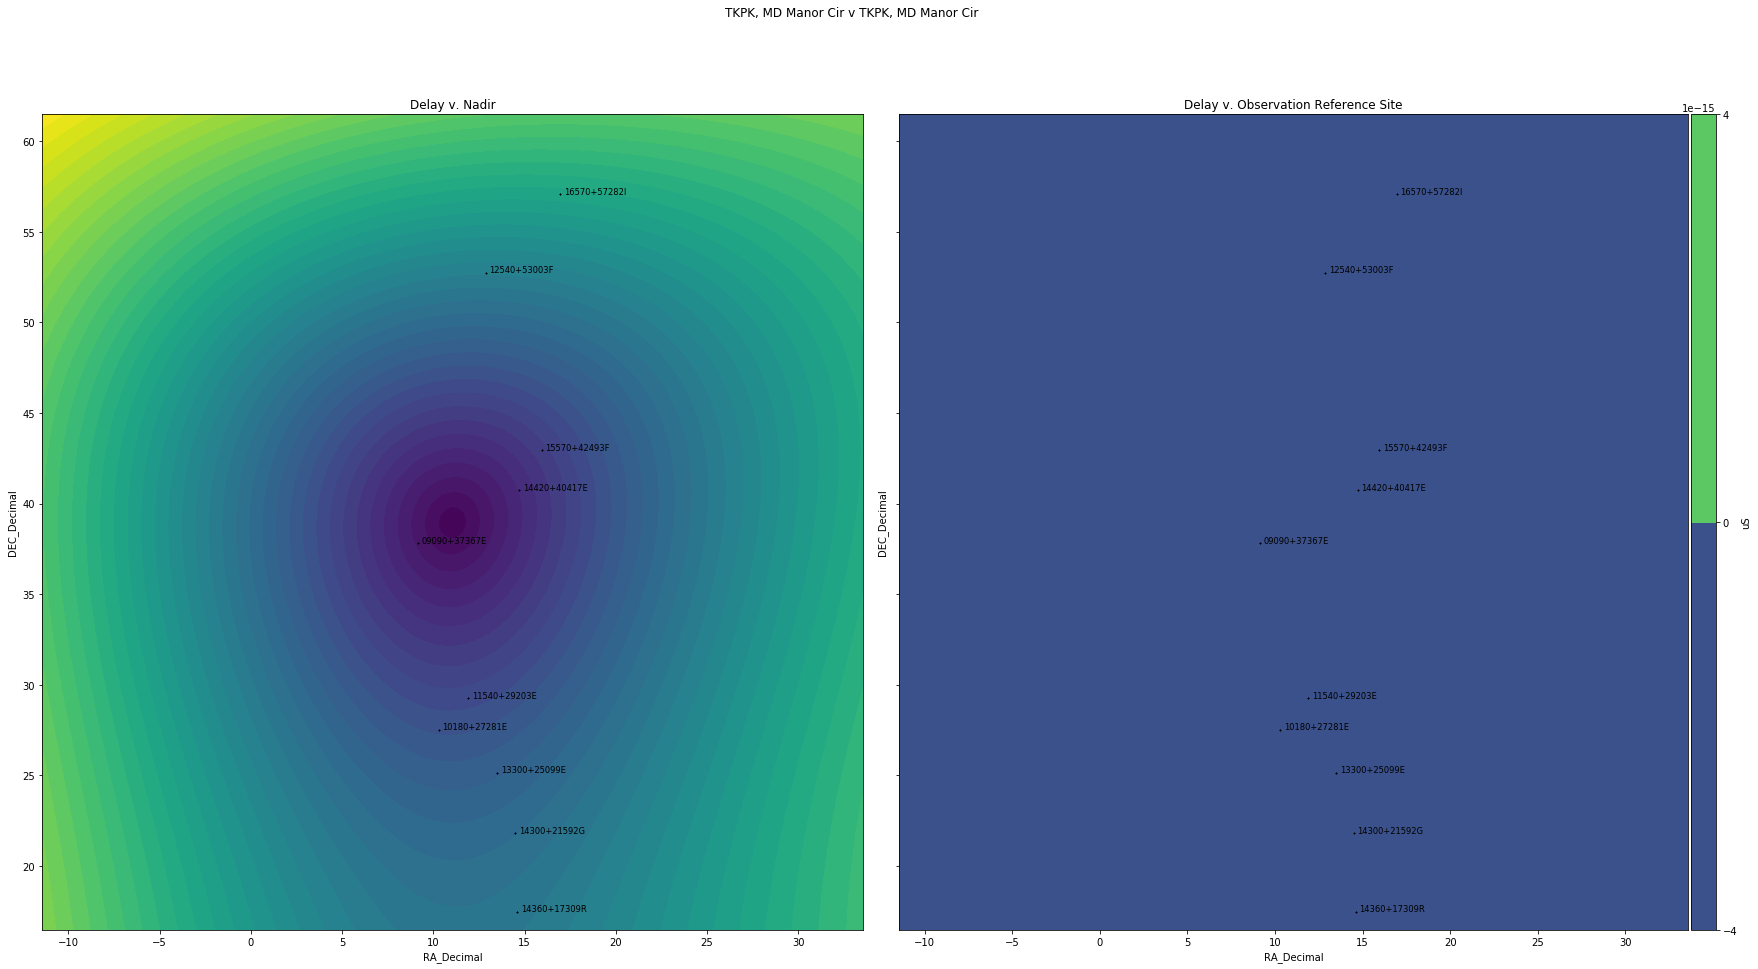

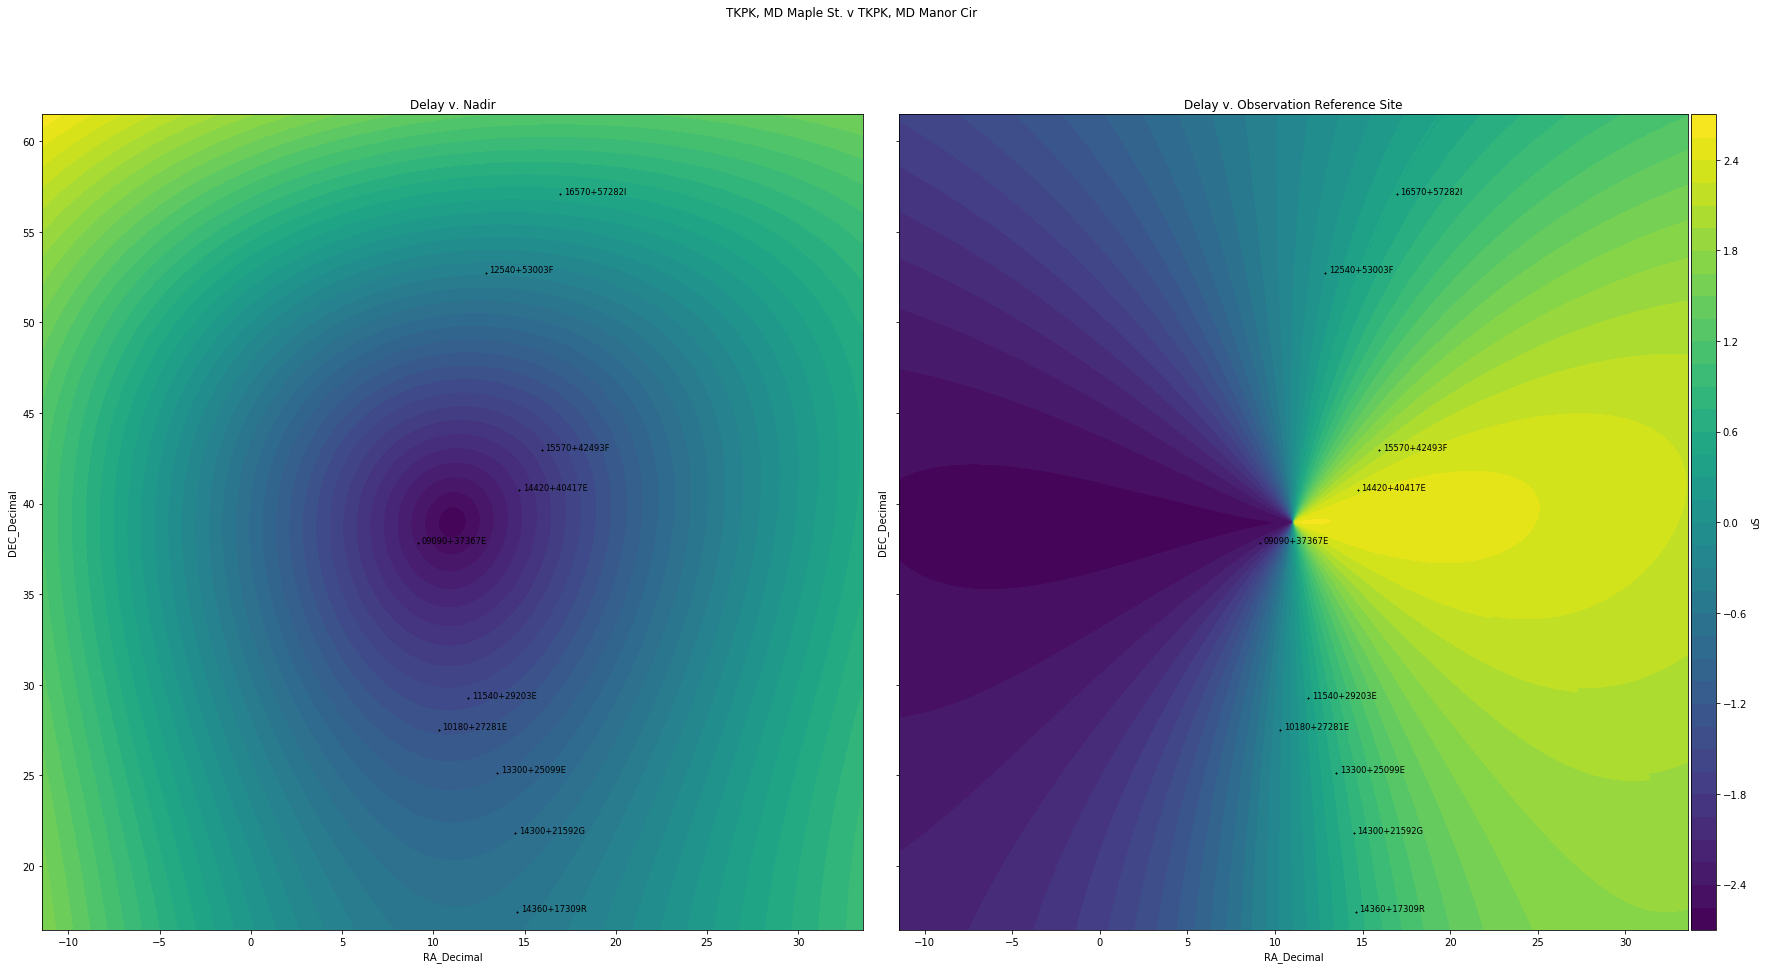

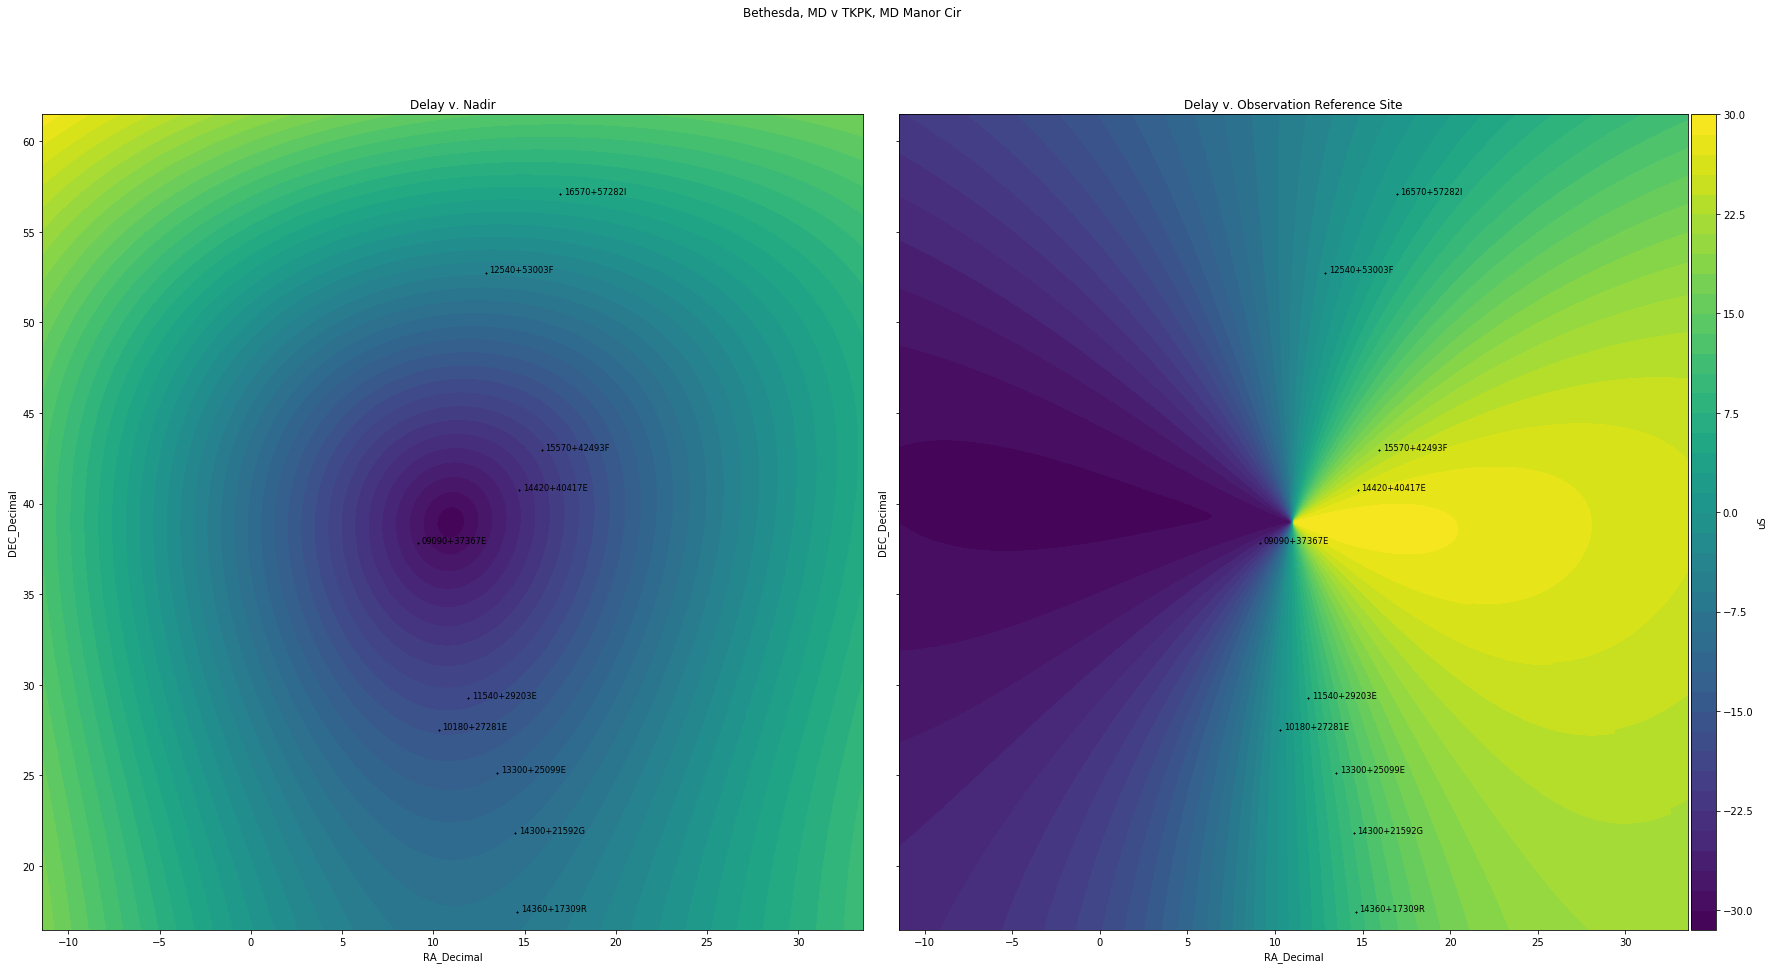

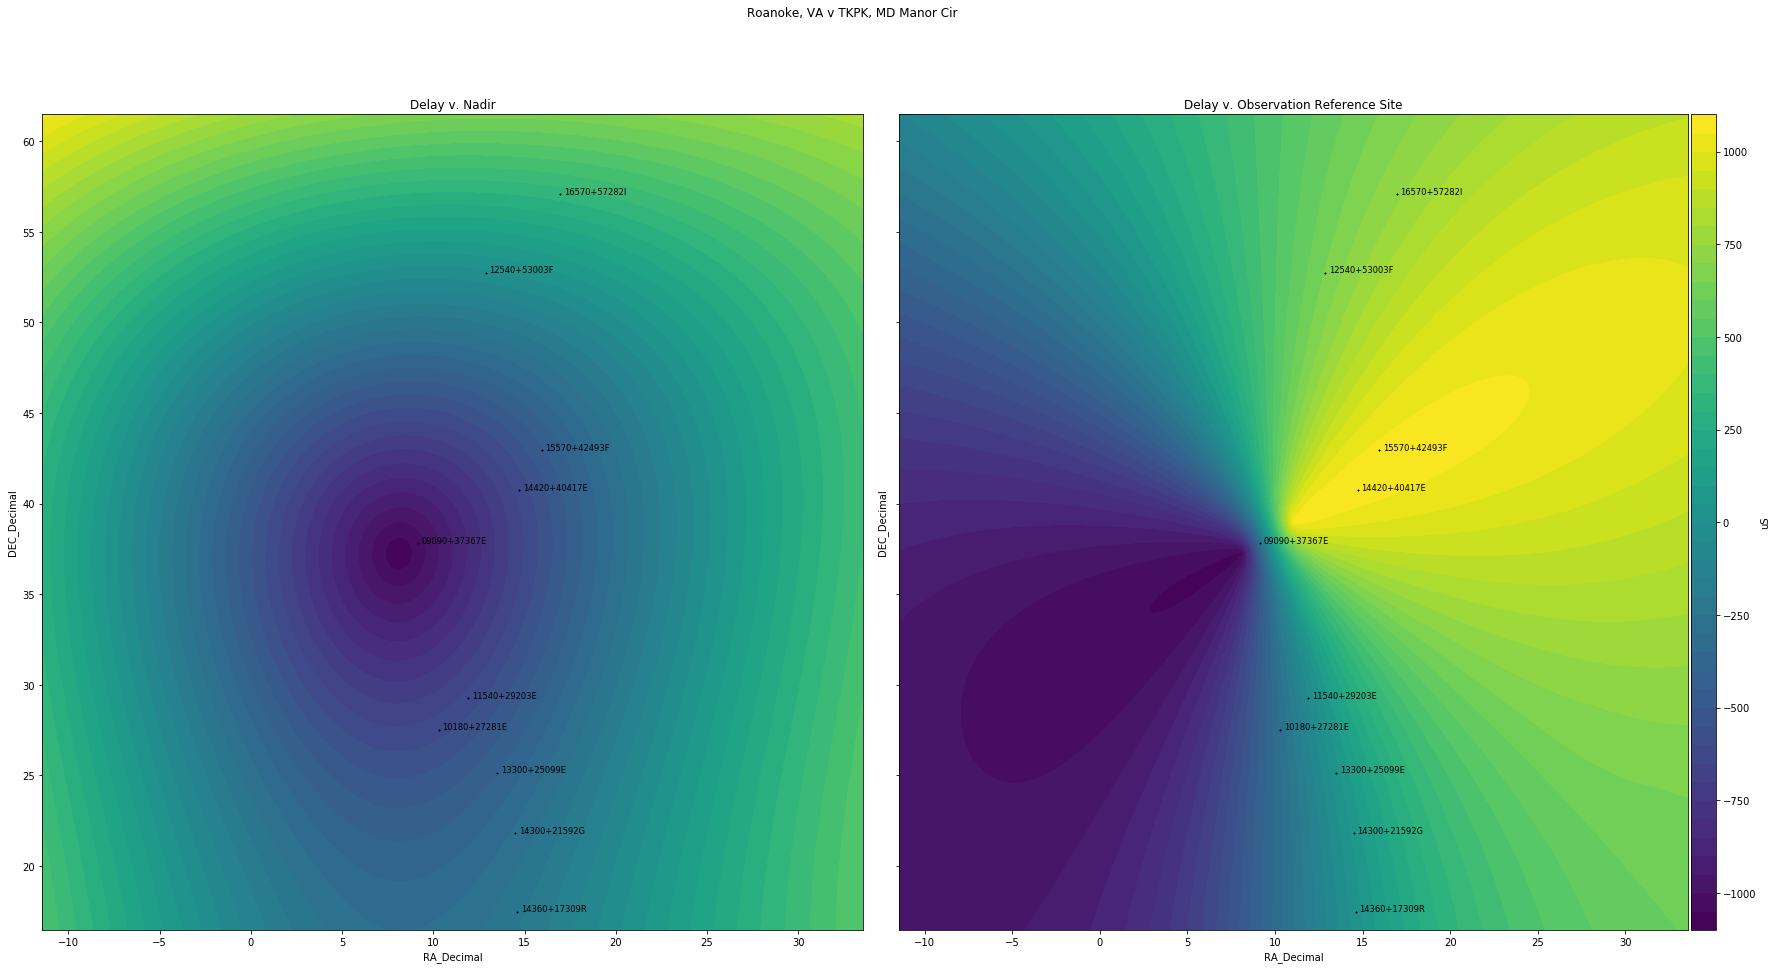

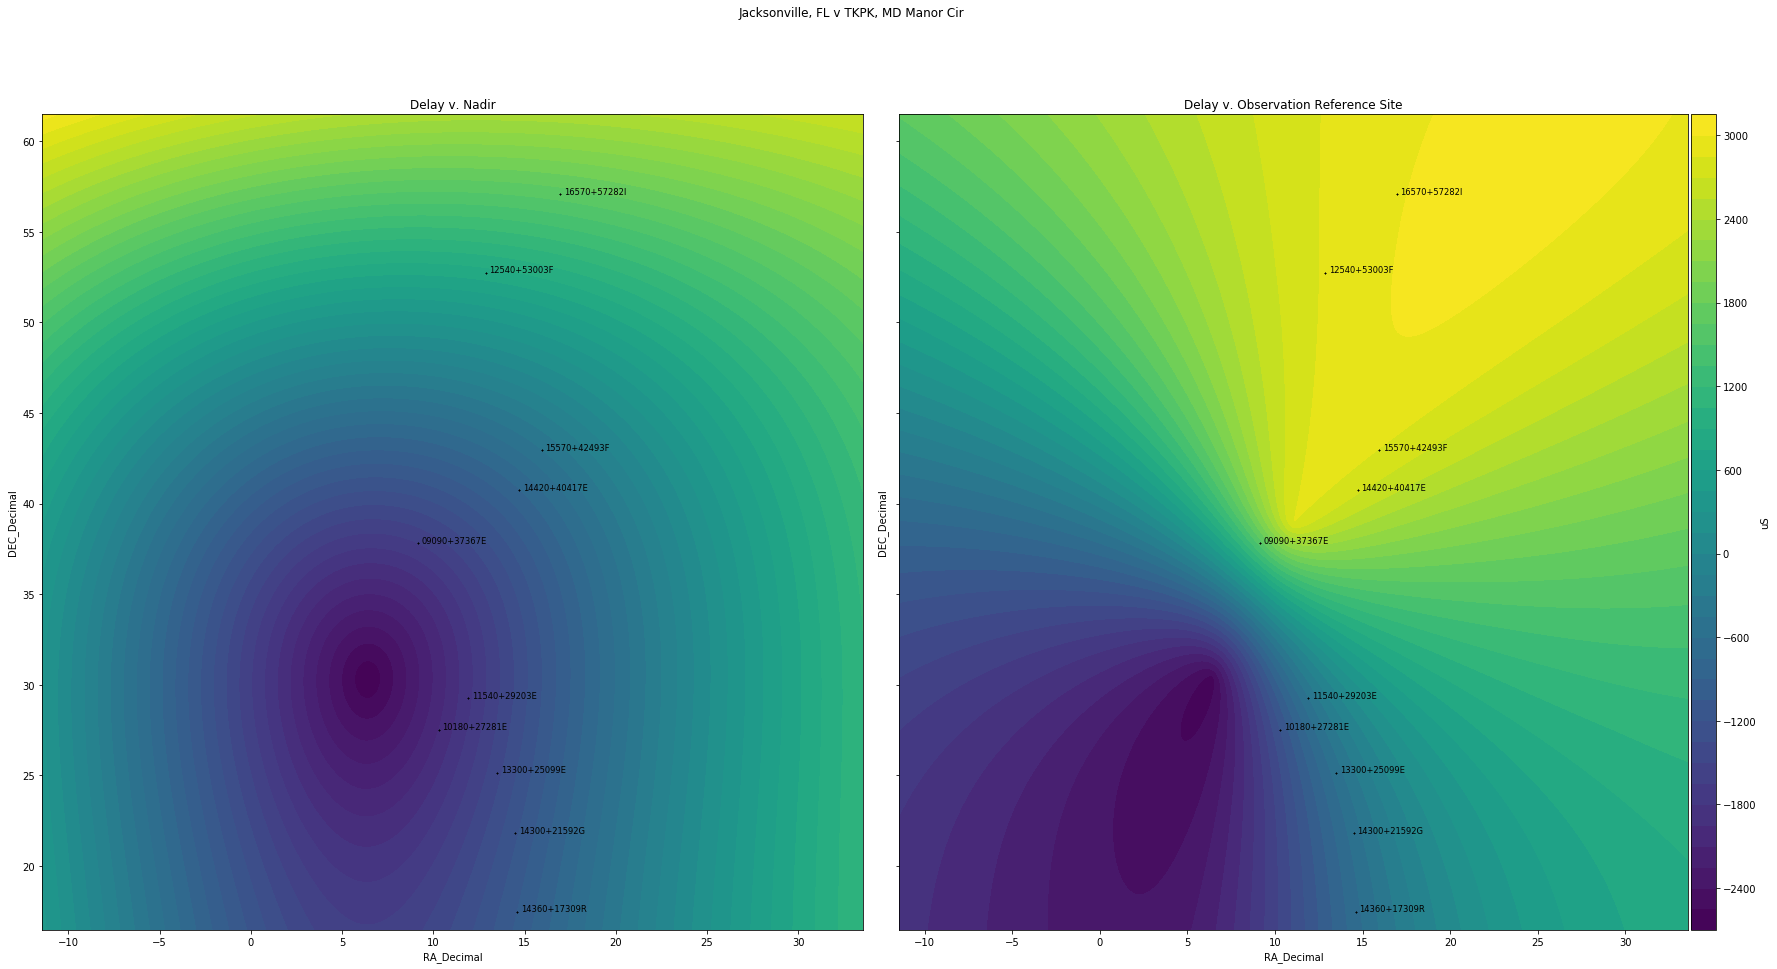

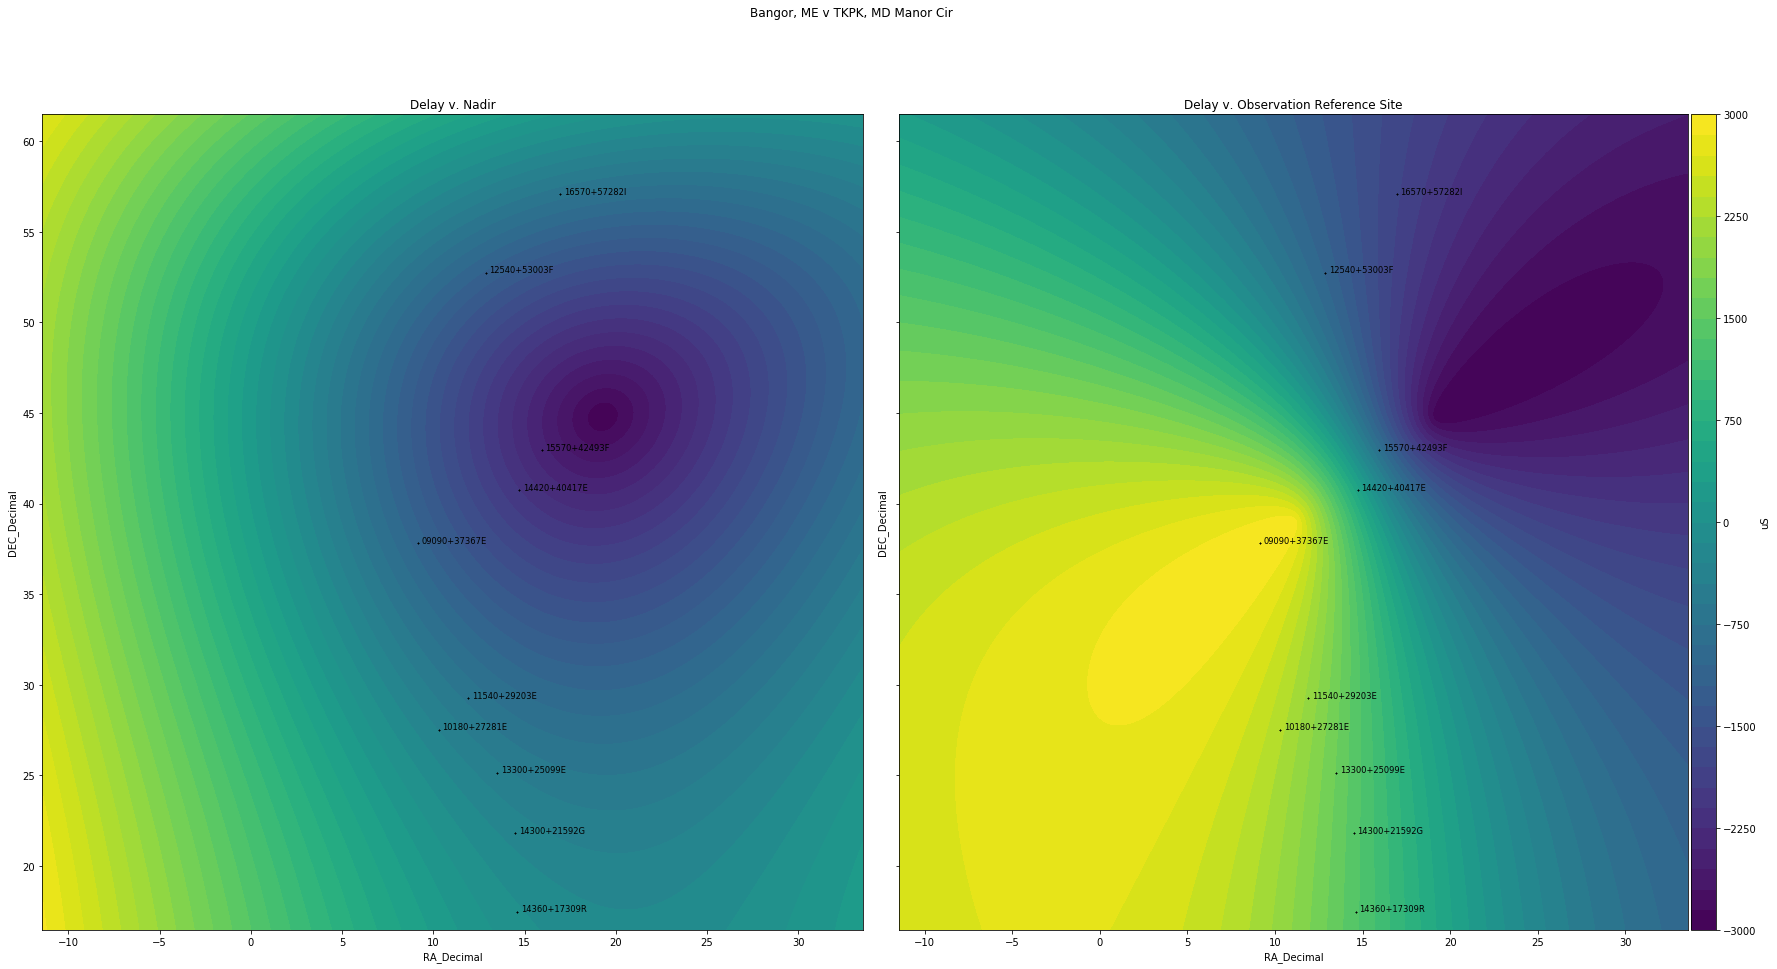

In [106]:
sites = [(lambda a: [a.x.value, a.y.value, a.z.value])(a) for a in [EarthLocation(
            lat=38.978897*u.deg, 
            lon=-77.004651*u.deg, 
            height=0*u.m),
         EarthLocation(
            lat=38.978695*u.deg, 
            lon=-77.012454*u.deg, 
            height=0*u.m),
        EarthLocation(
            lat=38.9847*u.deg, 
            lon=-77.0947*u.deg, 
            height=0*u.m),
        EarthLocation(
            lat=37.2710*u.deg, 
            lon=-79.9414*u.deg, 
            height=0*u.m),
        EarthLocation(
            lat=30.3322*u.deg, 
            lon=-81.6557*u.deg, 
            height=0*u.m),
        EarthLocation(
            lat=44.8016*u.deg, 
            lon=-68.7712*u.deg, 
            height=0*u.m)]]

sites[0].append("TKPK, MD Manor Cir")
sites[1].append("TKPK, MD Maple St.")
sites[2].append("Bethesda, MD")
sites[3].append("Roanoke, VA")
sites[4].append("Jacksonville, FL")
sites[5].append("Bangor, ME")

utctime = '2018-11-19 2:00:00'


ref_site = sites[0]
ref_loc = EarthLocation(x=ref_site[0]*u.m, y=ref_site[1]*u.m, z=ref_site[2]*u.m)

obstime = Time(utctime, location=ref_loc)
gast = obstime.sidereal_time('apparent', '0d').degree

centercoord=SkyCoord(
        ra=obstime.sidereal_time('apparent'), 
        dec=obstime.location.lat)

width=45
res=0.1

ra_grid, dec_grid = get_ra_dec_grids(centercoord.ra.degree, centercoord.dec.degree, res=res, width=width)

nadir_x, nadir_y, nadir_z = np.vectorize(get_nadir_xyz)(dec_grid, ra_grid, utctime, height=0)

matplotlib.rcParams['figure.figsize'] = [30, 15]


ref_matrix = geometric_delay(
        ra_grid, 
        dec_grid, 
        ref_site[0], 
        ref_site[1], 
        ref_site[2], 
        nadir_x,
        nadir_y,
        nadir_z,
        gast)

for site in sites:

    
    delay_matrix = geometric_delay(ra_grid, 
        dec_grid, 
        site[0], 
        site[1], 
        site[2], 
        nadir_x,
        nadir_y,
        nadir_z,
        gast)

    plot_matrix(delay_matrix, centercoord.ra.degree, centercoord.dec.degree, 
                width, ref_matrix=ref_matrix, label="%s v %s" % (site[3], ref_site[3]))
    

# print()
# print(ra_grid)
# print(dec_grid)